# Russell 2000 Stock Skewness Analysis

Question: Are companies usually convex in their early stage and become concave as they grow larger?

This notebook downloads Russell 2000 stock price data from Yahoo Finance, calculates the skewness of log returns, and creates visualizations comparing skewness to ticker history and market cap.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Load Russell 2000 Tickers and Download Stock Data


In [2]:
# Load Russell 2000 tickers from CSV
holdings_df = pd.read_csv('../data/IWM_holdings.csv')
tickers = holdings_df['Ticker'].tolist()
print(f"Total number of tickers: {len(tickers)}")


Total number of tickers: 2065


In [3]:
# # Download stock price data since 2000 and get market caps
# start_date = '2000-01-01'
# end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

# # Initialize dictionaries to store data
# price_data = {}
# market_caps = {}
# failed_tickers = []

# # Download data for each ticker
# print("Downloading stock data...")
# for ticker in tqdm(tickers):
#     if ticker in price_data:
#         continue
#     try:
#         # Download stock data
#         stock = yf.Ticker(ticker)
#         hist = stock.history(start=start_date, end=end_date)
        
#         if len(hist) > 0:
#             price_data[ticker] = hist['Close']
            
#             # Get market cap
#             try:
#                 info = stock.info
#                 if 'marketCap' in info and info['marketCap'] is not None:
#                     market_caps[ticker] = info['marketCap']
#                 else:
#                     market_caps[ticker] = np.nan
#             except:
#                 market_caps[ticker] = np.nan
#         else:
#             failed_tickers.append(ticker)
#     except Exception as e:
#         failed_tickers.append(ticker)
        
# print(f"\nSuccessfully downloaded data for {len(price_data)} tickers")
# print(f"Failed to download data for {len(failed_tickers)} tickers")


In [4]:
# # Create DataFrame from price data
# price_df = pd.DataFrame(price_data)
# print(f"Price data shape: {price_df.shape}")

# # Save price data to CSV
# price_df.to_csv('../data/russell2000_prices.csv')
# print("Saved price data to data/russell2000_prices.csv")

# # Save market caps to CSV
# mcap_df = pd.DataFrame(list(market_caps.items()), columns=['Ticker', 'MarketCap'])
# mcap_df.to_csv('../data/russell2000_marketcaps.csv', index=False)
# print("Saved market cap data to data/russell2000_marketcaps.csv")


## 2. Load Data and Calculate Skewness of Log Returns


In [32]:
# Load price data and market caps
price_df = pd.read_csv('../data/russell2000_prices.csv', index_col=0, parse_dates=True)
price_df.index = pd.to_datetime(price_df.index, utc=True)
mcap_df = pd.read_csv('../data/russell2000_marketcaps.csv')

# Create a dictionary for easy market cap lookup
mcap_dict = dict(zip(mcap_df['Ticker'], mcap_df['MarketCap']))

print(f"Loaded price data shape: {price_df.shape}")
print(f"Loaded market cap data for {len(mcap_dict)} tickers")


Loaded price data shape: (6415, 2049)
Loaded market cap data for 2049 tickers


In [8]:
# Calculate statistics for each ticker
results = []

for ticker in price_df.columns:
    prices = price_df[ticker].dropna()
    
    if len(prices) > 2:  # Need at least 3 prices for skewness
        # Calculate log returns
        log_returns = np.log(prices / prices.shift(1)).dropna()
        
        if len(log_returns) > 2:  # Need at least 3 returns for skewness
            # Calculate skewness
            skewness = stats.skew(log_returns)
            
            # Count non-NA days (ticker history)
            ticker_history = len(prices)
            
            # Get market cap
            market_cap = mcap_dict.get(ticker, np.nan)
            
            results.append({
                'ticker': ticker,
                'skewness': skewness,
                'ticker_history': ticker_history,
                'market_cap': market_cap
            })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Remove rows with NaN market cap for visualization
results_df_clean = results_df.dropna(subset=['market_cap'])

print(f"Calculated statistics for {len(results_df)} tickers")
print(f"After removing NaN market caps: {len(results_df_clean)} tickers")


Calculated statistics for 2049 tickers
After removing NaN market caps: 2044 tickers


## 3. Create Visualizations


### 3a. Skewness vs Ticker History


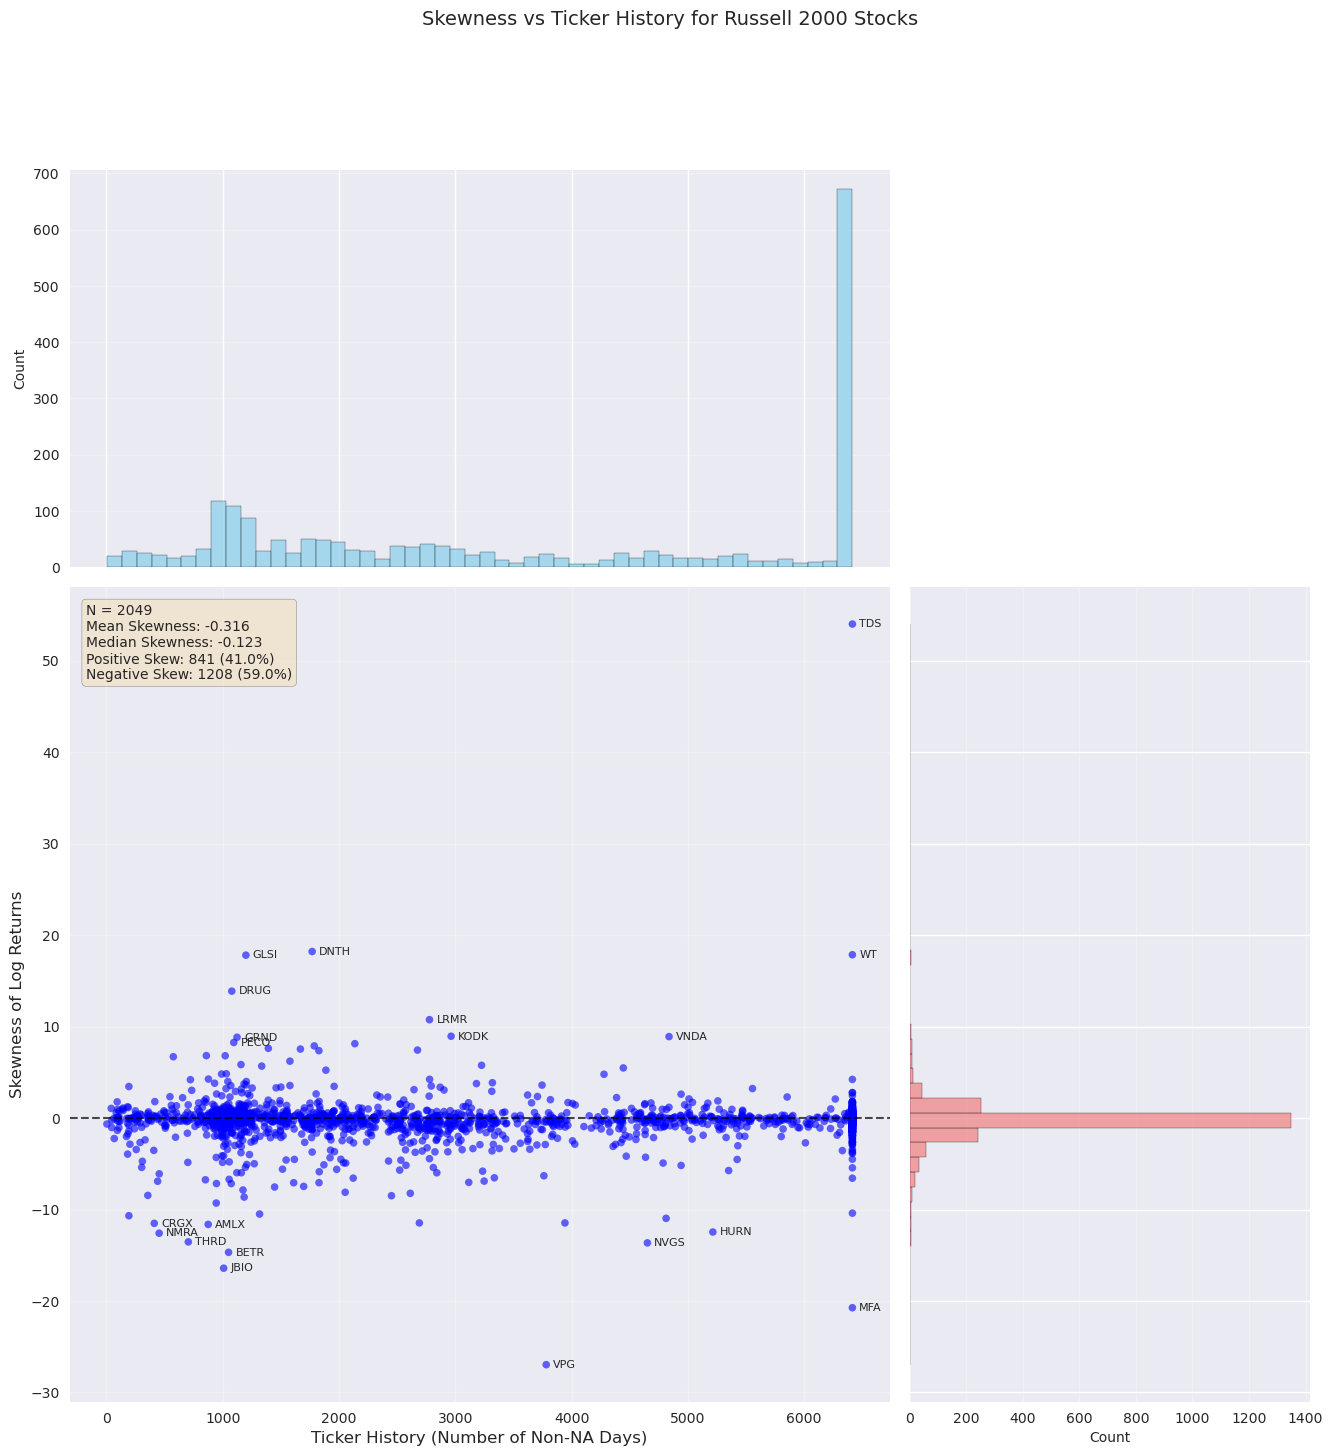

In [9]:
# Create figure with GridSpec
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(3, 3, hspace=0.05, wspace=0.05)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:, :-1])
ax_main.scatter(results_df['ticker_history'], results_df['skewness'], 
                alpha=0.6, s=30, c='blue', edgecolors='none')
ax_main.set_xlabel('Ticker History (Number of Non-NA Days)', fontsize=12)
ax_main.set_ylabel('Skewness of Log Returns', fontsize=12)
ax_main.grid(True, alpha=0.3)

# Add dashed black line at y=0
ax_main.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Find top 10 and bottom 10 stocks by skewness
top_10 = results_df.nlargest(10, 'skewness')
bottom_10 = results_df.nsmallest(10, 'skewness')

# Add ticker labels for top 10 and bottom 10
for idx, row in top_10.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['ticker_history'], row['skewness']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

for idx, row in bottom_10.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['ticker_history'], row['skewness']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

# Top histogram for ticker history
ax_hist_x = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_hist_x.hist(results_df['ticker_history'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax_hist_x.set_ylabel('Count', fontsize=10)
ax_hist_x.tick_params(axis='x', labelbottom=False)
ax_hist_x.grid(True, alpha=0.3, axis='y')

# Right histogram for skewness
ax_hist_y = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_hist_y.hist(results_df['skewness'], bins=50, alpha=0.7, color='lightcoral', 
               edgecolor='black', orientation='horizontal')
ax_hist_y.set_xlabel('Count', fontsize=10)
ax_hist_y.tick_params(axis='y', labelleft=False)
ax_hist_y.grid(True, alpha=0.3, axis='x')

# Add title
fig.suptitle('Skewness vs Ticker History for Russell 2000 Stocks', fontsize=14, y=0.98)

# Calculate positive and negative skewness counts
positive_skew = (results_df['skewness'] > 0).sum()
negative_skew = (results_df['skewness'] < 0).sum()
zero_skew = (results_df['skewness'] == 0).sum()
total = len(results_df)

# Add statistics text with positive/negative counts
stats_text = f"N = {total}\n"
stats_text += f"Mean Skewness: {results_df['skewness'].mean():.3f}\n"
stats_text += f"Median Skewness: {results_df['skewness'].median():.3f}\n"
stats_text += f"Positive Skew: {positive_skew} ({positive_skew/total*100:.1f}%)\n"
stats_text += f"Negative Skew: {negative_skew} ({negative_skew/total*100:.1f}%)"
ax_main.text(0.02, 0.98, stats_text, transform=ax_main.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


### 3b. Skewness vs Market Cap (Log Scale)


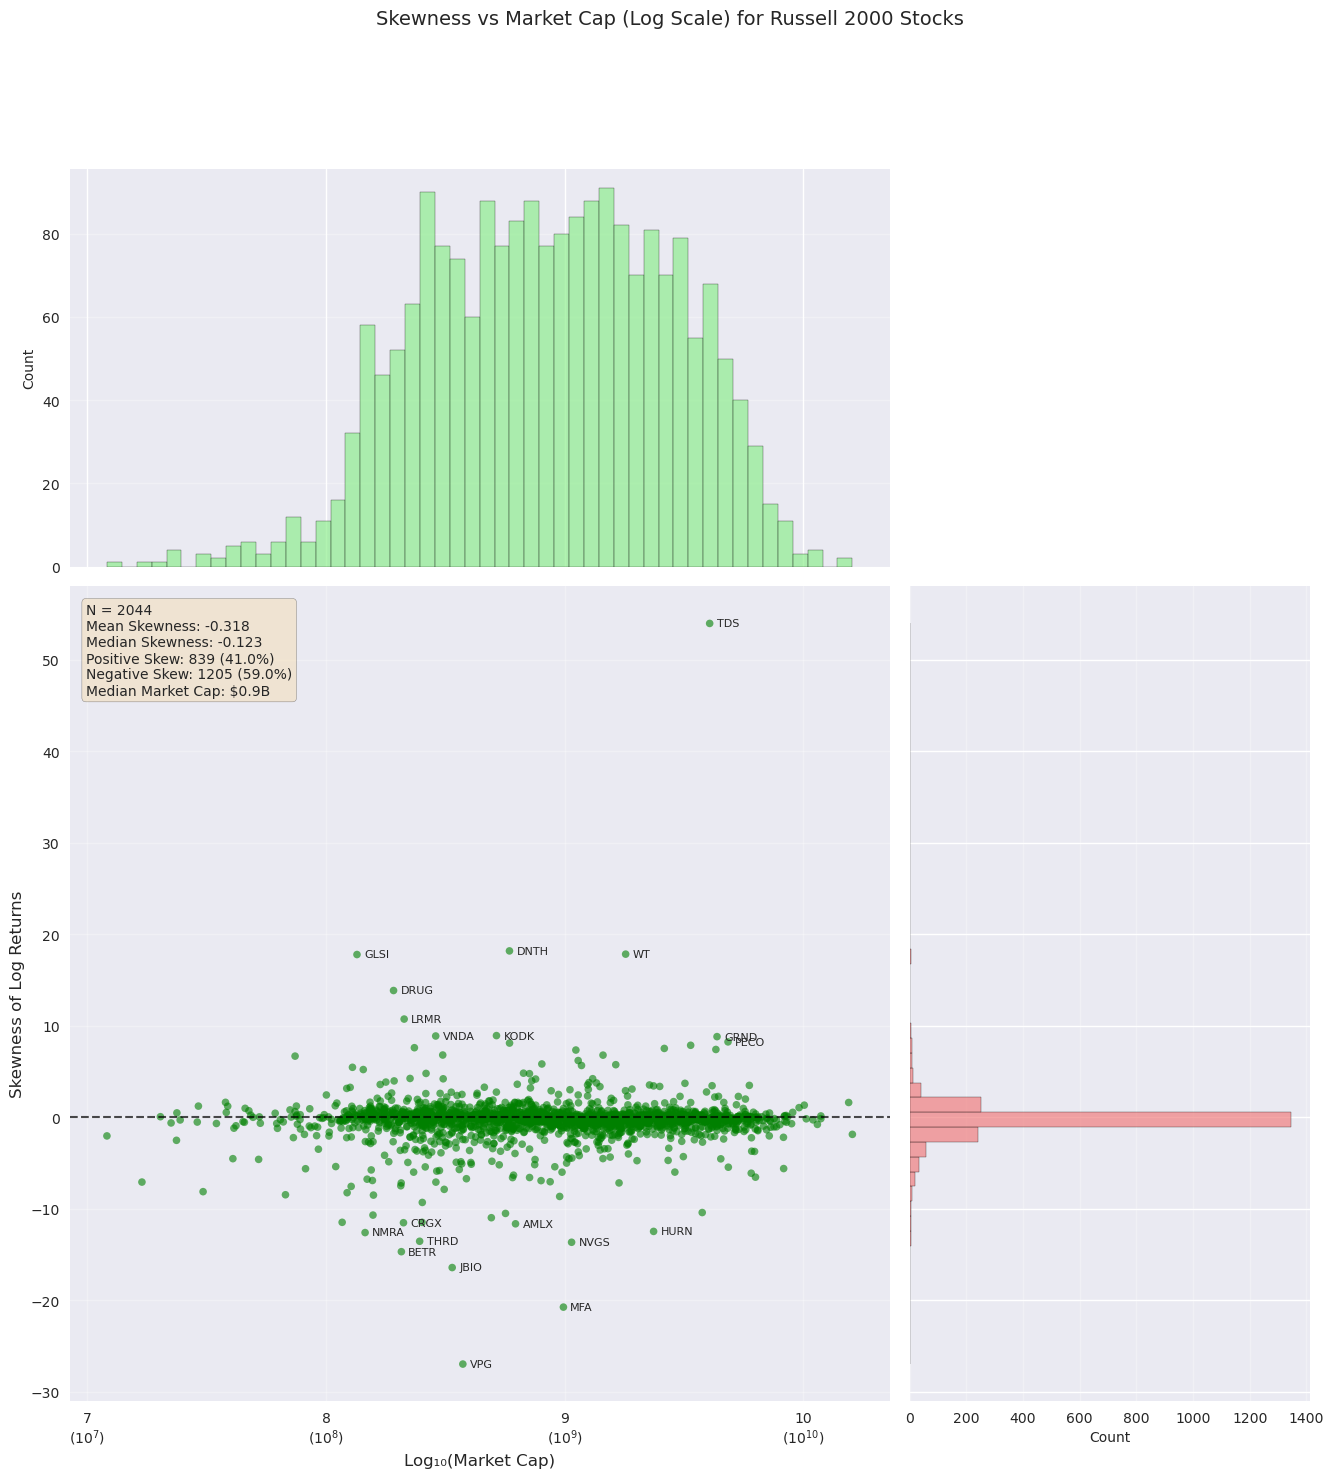

In [10]:
# Add log market cap column
results_df_clean['log_market_cap'] = np.log10(results_df_clean['market_cap'])

# Create figure with GridSpec
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(3, 3, hspace=0.05, wspace=0.05)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:, :-1])
ax_main.scatter(results_df_clean['log_market_cap'], results_df_clean['skewness'], 
                alpha=0.6, s=30, c='green', edgecolors='none')
ax_main.set_xlabel('Log₁₀(Market Cap)', fontsize=12)
ax_main.set_ylabel('Skewness of Log Returns', fontsize=12)
ax_main.grid(True, alpha=0.3)

# Add dashed black line at y=0
ax_main.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Find top 10 and bottom 10 stocks by skewness
top_10_clean = results_df_clean.nlargest(10, 'skewness')
bottom_10_clean = results_df_clean.nsmallest(10, 'skewness')

# Add ticker labels for top 10 and bottom 10
for idx, row in top_10_clean.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['log_market_cap'], row['skewness']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

for idx, row in bottom_10_clean.iterrows():
    ax_main.annotate(row['ticker'], 
                     (row['log_market_cap'], row['skewness']),
                     xytext=(5, 0), textcoords='offset points',
                     fontsize=8, ha='left', va='center')

# Format x-axis to show both log values and actual values
ax_main.set_xticks(np.arange(7, 12))
ax_main.set_xticklabels([f'{i}\n($10^{{{i}}}$)' for i in range(7, 12)])

# Top histogram for log market cap
ax_hist_x = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_hist_x.hist(results_df_clean['log_market_cap'], bins=50, alpha=0.7, 
               color='lightgreen', edgecolor='black')
ax_hist_x.set_ylabel('Count', fontsize=10)
ax_hist_x.tick_params(axis='x', labelbottom=False)
ax_hist_x.grid(True, alpha=0.3, axis='y')

# Right histogram for skewness
ax_hist_y = fig.add_subplot(gs[1:, -1], sharey=ax_main)
ax_hist_y.hist(results_df_clean['skewness'], bins=50, alpha=0.7, color='lightcoral', 
               edgecolor='black', orientation='horizontal')
ax_hist_y.set_xlabel('Count', fontsize=10)
ax_hist_y.tick_params(axis='y', labelleft=False)
ax_hist_y.grid(True, alpha=0.3, axis='x')

# Add title
fig.suptitle('Skewness vs Market Cap (Log Scale) for Russell 2000 Stocks', fontsize=14, y=0.98)

# Calculate positive and negative skewness counts
positive_skew_clean = (results_df_clean['skewness'] > 0).sum()
negative_skew_clean = (results_df_clean['skewness'] < 0).sum()
zero_skew_clean = (results_df_clean['skewness'] == 0).sum()
total_clean = len(results_df_clean)

# Add statistics text with positive/negative counts
stats_text = f"N = {total_clean}\n"
stats_text += f"Mean Skewness: {results_df_clean['skewness'].mean():.3f}\n"
stats_text += f"Median Skewness: {results_df_clean['skewness'].median():.3f}\n"
stats_text += f"Positive Skew: {positive_skew_clean} ({positive_skew_clean/total_clean*100:.1f}%)\n"
stats_text += f"Negative Skew: {negative_skew_clean} ({negative_skew_clean/total_clean*100:.1f}%)\n"
stats_text += f"Median Market Cap: ${results_df_clean['market_cap'].median()/1e9:.1f}B"
ax_main.text(0.02, 0.98, stats_text, transform=ax_main.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


In [13]:
# Display summary statistics
print("Summary Statistics for Russell 2000 Analysis")
print("=" * 50)
print(f"\nTotal tickers in IWM holdings: {len(tickers)}")
print(f"Successfully processed: {len(results_df)}")
print(f"With valid market cap data: {len(results_df_clean)}")

print("\nSkewness Statistics:")
print(f"Mean: {results_df['skewness'].mean():.4f}")
print(f"Median: {results_df['skewness'].median():.4f}")
print(f"Std Dev: {results_df['skewness'].std():.4f}")
print(f"Min: {results_df['skewness'].min():.4f}")
print(f"Max: {results_df['skewness'].max():.4f}")

print("\nTicker History Statistics:")
print(f"Mean days: {results_df['ticker_history'].mean():.0f}")
print(f"Median days: {results_df['ticker_history'].median():.0f}")
print(f"Min days: {results_df['ticker_history'].min()}")
print(f"Max days: {results_df['ticker_history'].max()}")

print("\nMarket Cap Statistics (for valid entries):")
print(f"Mean: ${results_df_clean['market_cap'].mean()/1e9:.2f}B")
print(f"Median: ${results_df_clean['market_cap'].median()/1e9:.2f}B")
print(f"Min: ${results_df_clean['market_cap'].min()/1e6:.0f}M")
print(f"Max: ${results_df_clean['market_cap'].max()/1e9:.2f}B")


Summary Statistics for Russell 2000 Analysis

Total tickers in IWM holdings: 2065
Successfully processed: 2049
With valid market cap data: 2044

Skewness Statistics:
Mean: -0.3160
Median: -0.1231
Std Dev: 2.5061
Min: -26.9622
Max: 53.9999

Ticker History Statistics:
Mean days: 3723
Median days: 3319
Min days: 4
Max days: 6415

Market Cap Statistics (for valid entries):
Mean: $1.54B
Median: $0.87B
Min: $12M
Max: $16.02B


In [21]:
# Download index data
indices = ['^GSPC', '^SPXEW', '^RUT', '^R2ESC']
index_names = ['S&P 500', 'S&P 500 Equal Weight', 'Russell 2000', 'Russell 2000 Equal Weight']

# Download data since 2000
start_date = '1990-01-01'
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

# Dictionary to store index data
index_data = {}

print("Downloading index data...")
for idx, name in zip(indices, index_names):
    try:
        data = yf.download(idx, start=start_date, end=end_date, progress=False)
        if len(data) > 0:
            index_data[name] = data['Close']
            print(f"✓ Downloaded {name} ({idx}): {len(data)} days")
        else:
            print(f"✗ No data for {name} ({idx})")
    except Exception as e:
        print(f"✗ Error downloading {name} ({idx}): {str(e)}")

print(f"\nSuccessfully downloaded data for {len(index_data)} indices")


✓ Downloaded S&P 500 (^GSPC): 8943 days
✓ Downloaded S&P 500 Equal Weight (^SPXEW): 4657 days



1 Failed download:
['^R2ESC']: YFPricesMissingError('possibly delisted; no price data found  (1d 1990-01-01 -> 2025-07-08)')


✓ Downloaded Russell 2000 (^RUT): 8943 days
✗ No data for Russell 2000 Equal Weight (^R2ESC)

Successfully downloaded data for 3 indices


In [34]:
# Calculate rolling skewness for each index
window = 252*2  # 2 years of trading days
rolling_skewness = {}

for name, prices in index_data.items():
    # Calculate log returns
    log_returns = np.log(prices / prices.shift(1)).dropna()
    
    # Calculate rolling skewness
    rolling_skew = log_returns.rolling(window=window).apply(lambda x: stats.skew(x), raw=False)
    rolling_skewness[name] = rolling_skew
    
print(f"Calculated rolling skewness for {len(rolling_skewness)} indices")


Calculated rolling skewness for 3 indices


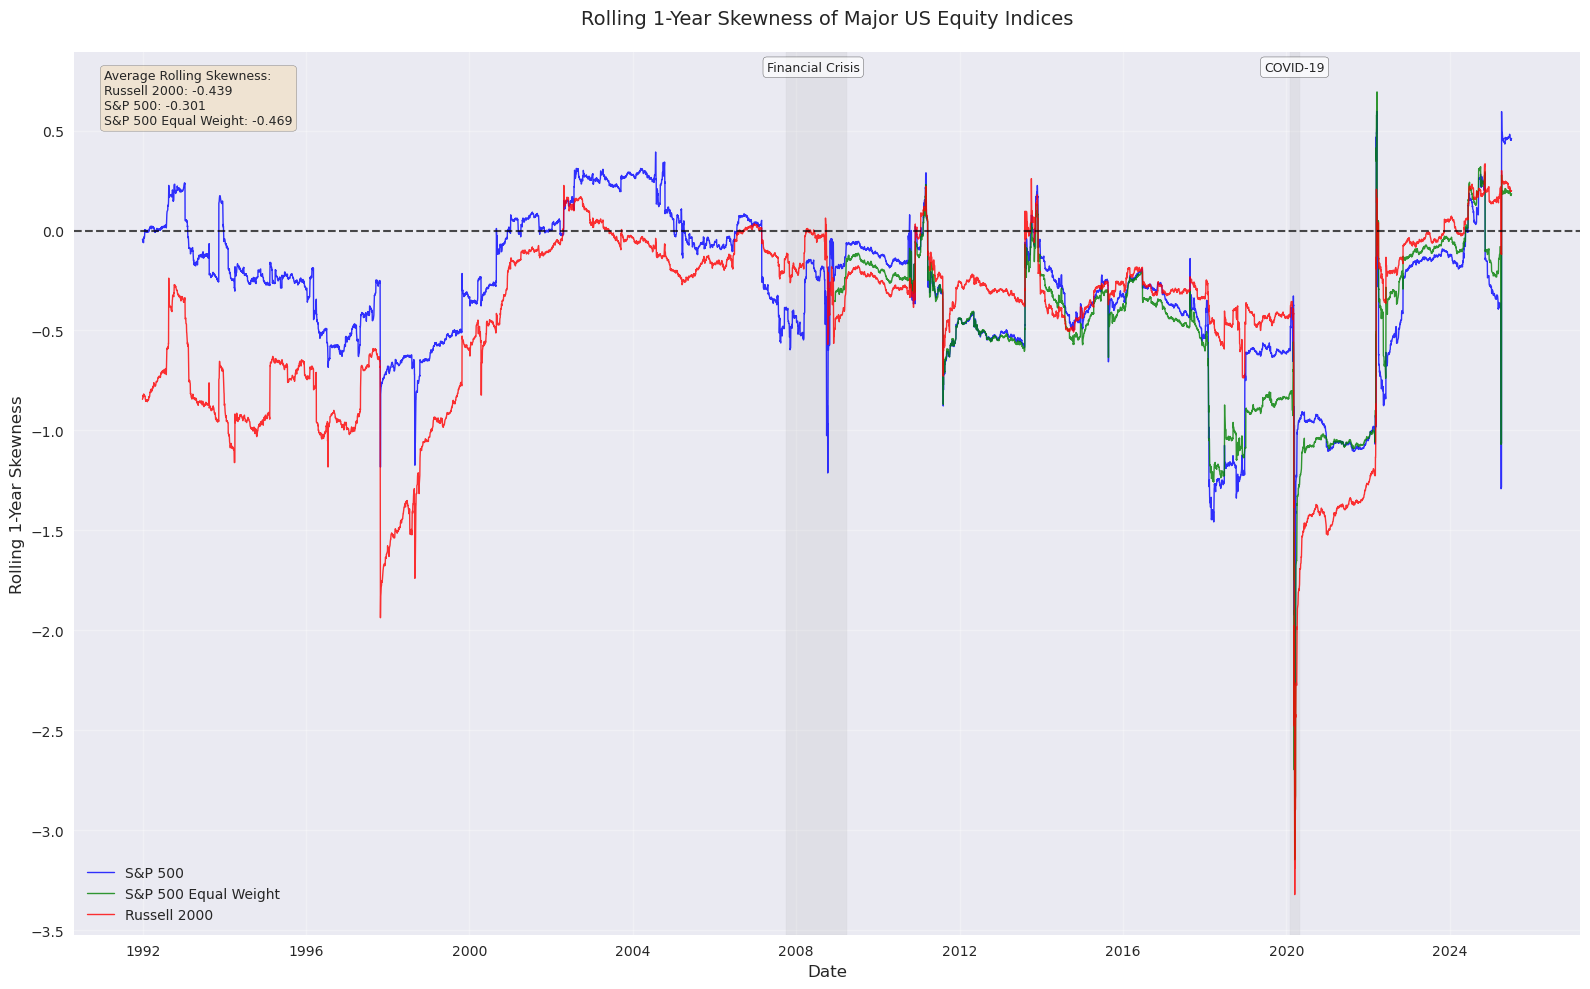


Rolling Skewness Summary Statistics:

S&P 500:
  Mean: -0.3014
  Median: -0.2562
  Std Dev: 0.3626
  Min: -2.2728 (on Ticker
^GSPC    2020-03-16
dtype: object)
  Max: 0.5960 (on Ticker
^GSPC    2022-03-22
dtype: object)
  Current: 0.4608

S&P 500 Equal Weight:
  Mean: -0.4691
  Median: -0.4004
  Std Dev: 0.3875
  Min: -3.1480 (on Ticker
^SPXEW    2020-03-16
dtype: object)
  Max: 0.6935 (on Ticker
^SPXEW    2022-03-22
dtype: object)
  Current: 0.1843

Russell 2000:
  Mean: -0.4394
  Median: -0.3034
  Std Dev: 0.4471
  Min: -3.3228 (on Ticker
^RUT    2020-03-16
dtype: object)
  Max: 0.3338 (on Ticker
^RUT    2024-11-12
dtype: object)
  Current: 0.2004


In [36]:
# Create rolling skewness plot
fig, ax = plt.subplots(figsize=(16, 10))

# Define colors for each index
colors = {'S&P 500': 'blue', 
          'S&P 500 Equal Weight': 'green',
          'Russell 2000': 'red', 
          'Russell 2000 Equal Weight': 'salmon'}

# Plot each index's rolling skewness
for name, skew_series in rolling_skewness.items():
    ax.plot(skew_series.index, skew_series.values, 
            label=name, linewidth=1, alpha=0.8, color=colors.get(name, 'gray'))

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rolling 1-Year Skewness', fontsize=12)
ax.set_title('Rolling 1-Year Skewness of Major US Equity Indices', fontsize=14, pad=20)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Add shaded regions for major market events (optional)
# Financial Crisis
ax.axvspan(pd.to_datetime('2007-10-01'), pd.to_datetime('2009-03-31'), 
           alpha=0.1, color='gray', label='Financial Crisis')
# COVID-19
ax.axvspan(pd.to_datetime('2020-02-01'), pd.to_datetime('2020-04-30'), 
           alpha=0.1, color='gray')

# Add text annotations for crisis periods
ax.text(pd.to_datetime('2008-06-01'), ax.get_ylim()[1]*0.95, 
        'Financial Crisis', fontsize=9, ha='center', va='top', 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
ax.text(pd.to_datetime('2020-03-15'), ax.get_ylim()[1]*0.95, 
        'COVID-19', fontsize=9, ha='center', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Calculate and display summary statistics
stats_text = "Average Rolling Skewness:\n"
for name in sorted(rolling_skewness.keys()):
    skew_values = rolling_skewness[name].dropna()
    if isinstance(skew_values, pd.Series) or isinstance(skew_values, pd.DataFrame):
        mean_skew = float(skew_values.mean())
    else:
        mean_skew = float(skew_values)
    stats_text += f"{name}: {mean_skew:.3f}\n"

ax.text(0.02, 0.98, stats_text.strip(), transform=ax.transAxes, 
        verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nRolling Skewness Summary Statistics:")
print("="*50)
for name, skew_series in rolling_skewness.items():
    clean_skew = skew_series.dropna()
    print(f"\n{name}:")
    print(f"  Mean: {float(clean_skew.mean()):.4f}")
    print(f"  Median: {float(clean_skew.median()):.4f}")
    print(f"  Std Dev: {float(clean_skew.std()):.4f}")
    print(f"  Min: {float(clean_skew.min()):.4f} (on {clean_skew.idxmin().dt.strftime('%Y-%m-%d')})")
    print(f"  Max: {float(clean_skew.max()):.4f} (on {clean_skew.idxmax().dt.strftime('%Y-%m-%d')})")
    print(f"  Current: {float(clean_skew.iloc[-1]):.4f}")


## 6. Year-by-Year Skewness Analysis

This section analyzes how stock skewness evolves year-by-year from when each stock first appears in the data, investigating whether companies are convex (antifragile) in their early stages and become concave (fragile) as they mature.


In [43]:
# # Load the price data
# price_df = pd.read_csv('../data/russell2000_prices.csv', index_col=0, parse_dates=True)
# price_df.index = pd.to_datetime(price_df.index, utc=True)

# Identify the maximum number of days in the dataset
max_days = len(price_df)
print(f"Total trading days in dataset: {max_days}")

# Filter out stocks with full history (since we don't know when they started)
stocks_with_partial_history = []
for ticker in price_df.columns:
    if price_df[ticker].dropna().index[0] > price_df.index[0] + pd.Timedelta(days=5):
        stocks_with_partial_history.append(ticker)

print(f"Stocks with partial history: {len(stocks_with_partial_history)}")
print(f"Stocks with full history (excluded): {len(price_df.columns) - len(stocks_with_partial_history)}")


Total trading days in dataset: 6415
Stocks with partial history: 1387
Stocks with full history (excluded): 662


In [44]:
# Calculate year-by-year skewness for each stock
TRADING_DAYS_PER_YEAR = 252

# Dictionary to store yearly skewness for each stock
yearly_skewness_dict = {}

for ticker in tqdm(stocks_with_partial_history, desc="Processing stocks"):
    # Get the price series for this ticker
    prices = price_df[ticker].dropna()
    
    if len(prices) < TRADING_DAYS_PER_YEAR:  # Skip if less than 1 year of data
        continue
    
    # Calculate log returns
    log_returns = np.log(prices / prices.shift(1)).dropna()
    
    # Calculate skewness for each year
    yearly_skewness = []
    max_years = len(log_returns) // TRADING_DAYS_PER_YEAR
    
    for year in range(1, max_years + 1):
        start_idx = (year - 1) * TRADING_DAYS_PER_YEAR
        end_idx = year * TRADING_DAYS_PER_YEAR
        
        if end_idx <= len(log_returns):
            year_returns = log_returns.iloc[start_idx:end_idx]
            if len(year_returns) >= 100:  # Require at least 100 days for reliable skewness
                skew = stats.skew(year_returns)
                yearly_skewness.append(skew)
            else:
                yearly_skewness.append(np.nan)
        else:
            # Handle partial year at the end
            year_returns = log_returns.iloc[start_idx:]
            if len(year_returns) >= 100:
                skew = stats.skew(year_returns)
                yearly_skewness.append(skew)
            else:
                yearly_skewness.append(np.nan)
    
    yearly_skewness_dict[ticker] = yearly_skewness

print(f"\nProcessed {len(yearly_skewness_dict)} stocks with yearly skewness data")


Processing stocks: 100%|██████████| 1387/1387 [00:03<00:00, 374.97it/s]


Processed 1341 stocks with yearly skewness data


In [45]:
# Create DataFrame with stocks as columns and years as index
# Find the maximum number of years for any stock
max_years_in_data = max(len(skewness_list) for skewness_list in yearly_skewness_dict.values())

# Create the DataFrame
yearly_skewness_df = pd.DataFrame(
    index=range(1, max_years_in_data + 1),
    columns=list(yearly_skewness_dict.keys())
)

# Fill the DataFrame
for ticker, skewness_list in yearly_skewness_dict.items():
    for year_idx, skew_value in enumerate(skewness_list):
        yearly_skewness_df.loc[year_idx + 1, ticker] = skew_value

# Convert to numeric
yearly_skewness_df = yearly_skewness_df.astype(float)

print(f"Yearly skewness DataFrame shape: {yearly_skewness_df.shape}")
print(f"Years covered: {yearly_skewness_df.index.min()} to {yearly_skewness_df.index.max()}")

# Display summary statistics for each year
print("\nNumber of stocks with data for each year:")
for year in yearly_skewness_df.index[:10]:  # Show first 10 years
    non_na_count = yearly_skewness_df.loc[year].notna().sum()
    print(f"Year {year}: {non_na_count} stocks")
print("...")


Yearly skewness DataFrame shape: (25, 1341)
Years covered: 1 to 25

Number of stocks with data for each year:
Year 1: 1340 stocks
Year 2: 1296 stocks
Year 3: 1257 stocks
Year 4: 1124 stocks
Year 5: 916 stocks
Year 6: 846 stocks
Year 7: 768 stocks
Year 8: 683 stocks
Year 9: 615 stocks
Year 10: 569 stocks
...


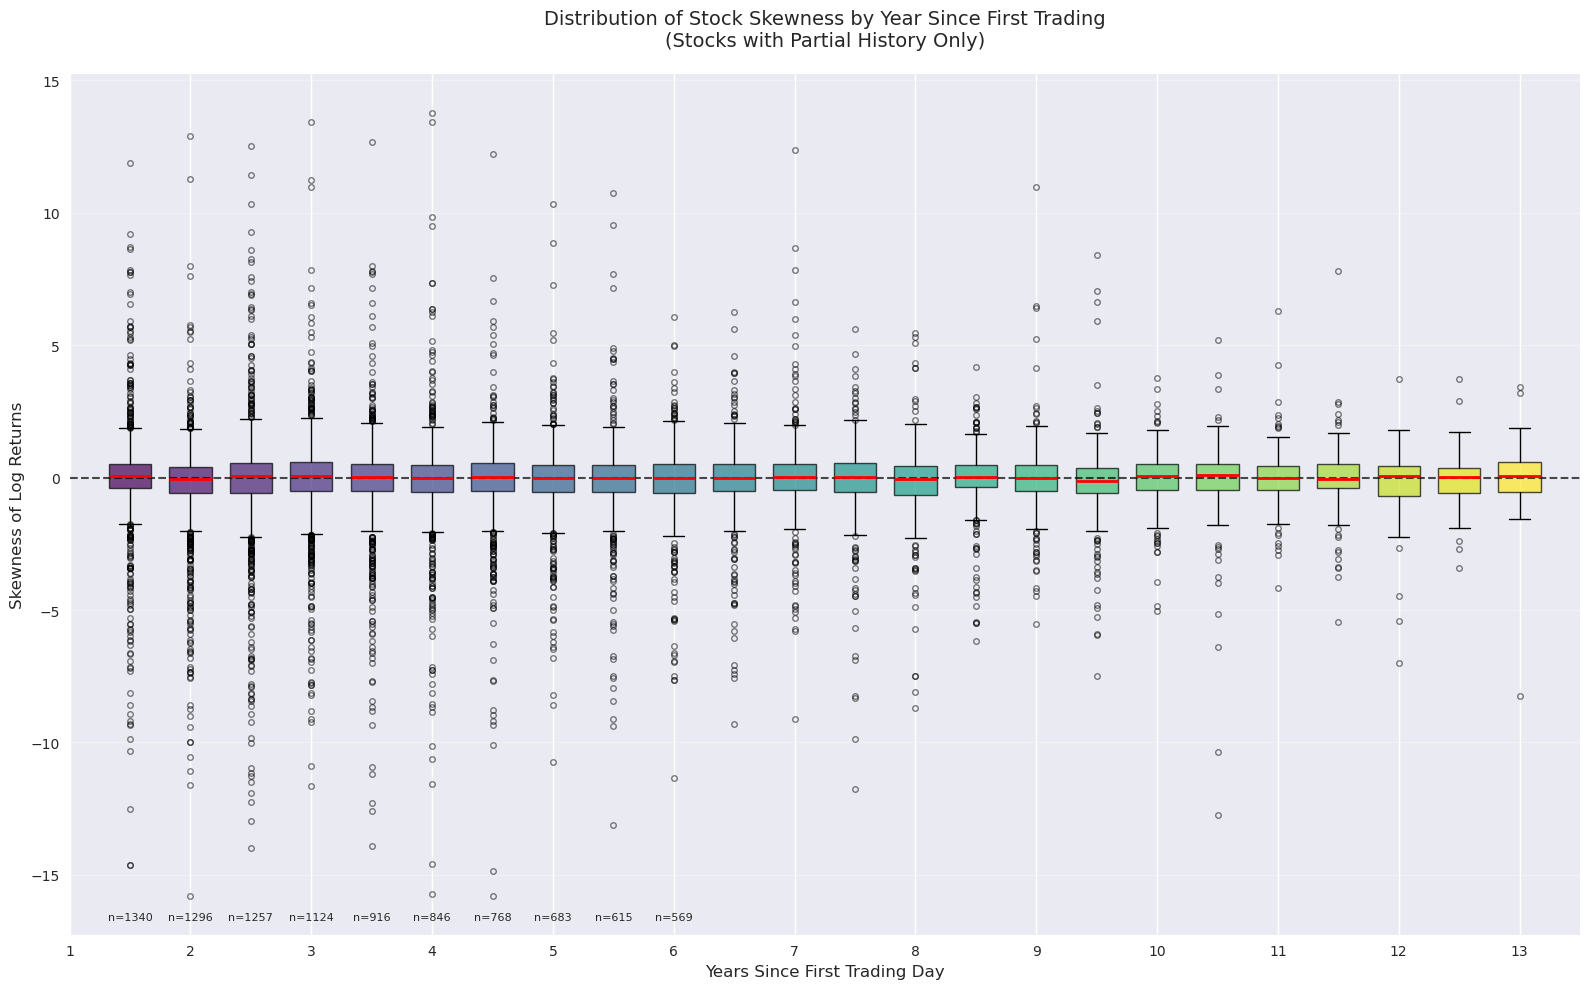


Summary statistics by year:
------------------------------------------------------------
Year   Count    Mean       Median     Std Dev   
------------------------------------------------------------
1      1340     -0.0157    0.0422     1.8325    
2      1296     -0.2963    -0.0521    1.8100    
3      1257     -0.1484    0.0560     2.1856    
4      1124     -0.0781    0.0467     1.8597    
5      916      -0.1749    0.0272     1.9761    
6      846      -0.1847    -0.0255    2.0886    
7      768      -0.1564    0.0049     1.8365    
8      683      -0.1379    -0.0008    1.6387    
9      615      -0.1667    -0.0019    1.7969    
10     569      -0.2046    -0.0314    1.6154    
11     497      -0.1419    -0.0189    1.5562    
12     421      0.0172     0.0354     1.7140    
13     372      -0.1385    0.0279     1.7227    
14     341      -0.2284    -0.0512    1.5756    
15     311      -0.0954    0.0152     1.3097    


In [46]:
# Create box plot of skewness distribution by year
fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data for box plot - only include years with sufficient data
min_stocks_per_year = 20
years_to_plot = []
data_to_plot = []

for year in yearly_skewness_df.index:
    year_data = yearly_skewness_df.loc[year].dropna()
    if len(year_data) >= min_stocks_per_year:
        years_to_plot.append(year)
        data_to_plot.append(year_data.values)
    else:
        break  # Stop when we don't have enough stocks

# Create box plot
bp = ax.boxplot(data_to_plot, positions=years_to_plot, widths=0.7, patch_artist=True,
                medianprops=dict(color='red', linewidth=2),
                flierprops=dict(marker='o', markersize=4, alpha=0.5))

# Color the boxes with a gradient
colors = plt.cm.viridis(np.linspace(0, 1, len(years_to_plot)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Formatting
ax.set_xlabel('Years Since First Trading Day', fontsize=12)
ax.set_ylabel('Skewness of Log Returns', fontsize=12)
ax.set_title('Distribution of Stock Skewness by Year Since First Trading\n(Stocks with Partial History Only)', 
             fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='y')

# Set x-axis limits and ticks
ax.set_xlim(0, max(years_to_plot) + 1)
ax.set_xticks(range(0, max(years_to_plot) + 1, 2))

# Add sample size annotations
for i, (year, data) in enumerate(zip(years_to_plot[:10], data_to_plot[:10])):
    ax.text(year, ax.get_ylim()[0] * 0.95, f'n={len(data)}', 
            ha='center', va='top', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary statistics by year:")
print("-" * 60)
print(f"{'Year':<6} {'Count':<8} {'Mean':<10} {'Median':<10} {'Std Dev':<10}")
print("-" * 60)
for year in years_to_plot[:15]:  # Show first 15 years
    year_data = yearly_skewness_df.loc[year].dropna()
    print(f"{year:<6} {len(year_data):<8} {year_data.mean():<10.4f} {year_data.median():<10.4f} {year_data.std():<10.4f}")


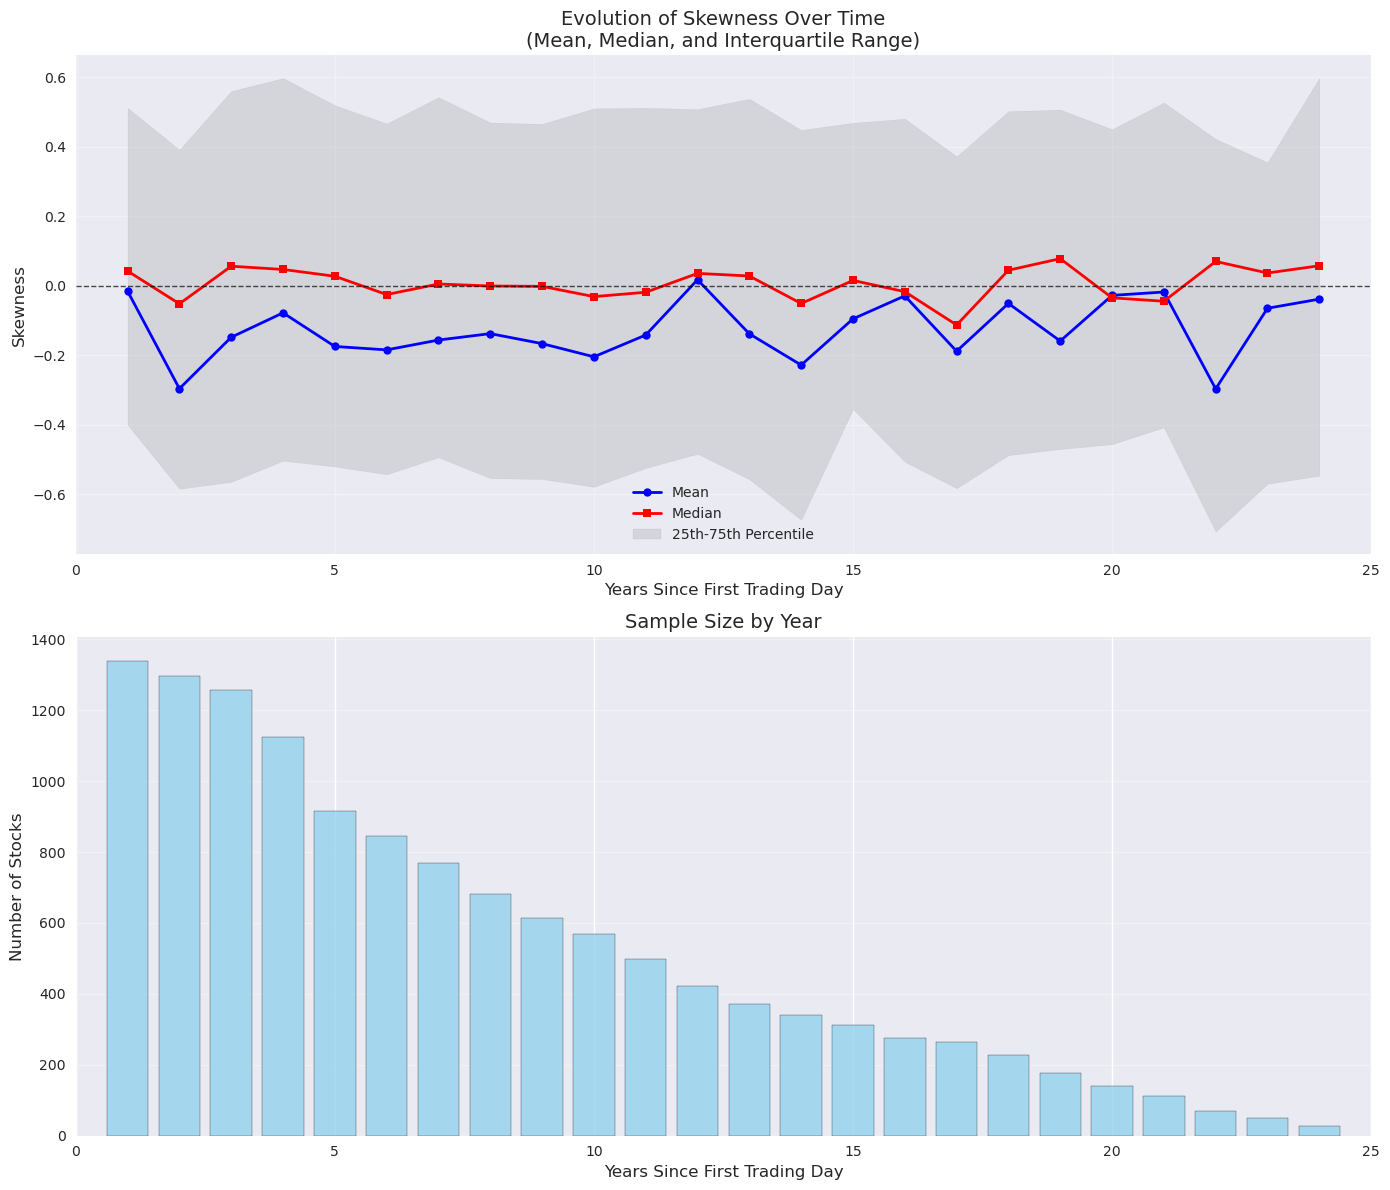


Linear regression analysis (first 10 years):
Slope: -0.0060
R-squared: 0.0594
P-value: 0.4972
Conclusion: No significant trend detected


In [47]:
# Plot trend of mean and median skewness over years
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Calculate statistics for each year
years_with_data = []
mean_skewness = []
median_skewness = []
percentile_25 = []
percentile_75 = []
sample_sizes = []

for year in yearly_skewness_df.index:
    year_data = yearly_skewness_df.loc[year].dropna()
    if len(year_data) >= min_stocks_per_year:
        years_with_data.append(year)
        mean_skewness.append(year_data.mean())
        median_skewness.append(year_data.median())
        percentile_25.append(year_data.quantile(0.25))
        percentile_75.append(year_data.quantile(0.75))
        sample_sizes.append(len(year_data))
    else:
        break

# Plot 1: Mean and Median Skewness
ax1.plot(years_with_data, mean_skewness, 'b-', linewidth=2, label='Mean', marker='o', markersize=6)
ax1.plot(years_with_data, median_skewness, 'r-', linewidth=2, label='Median', marker='s', markersize=6)
ax1.fill_between(years_with_data, percentile_25, percentile_75, alpha=0.2, color='gray', label='25th-75th Percentile')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax1.set_xlabel('Years Since First Trading Day', fontsize=12)
ax1.set_ylabel('Skewness', fontsize=12)
ax1.set_title('Evolution of Skewness Over Time\n(Mean, Median, and Interquartile Range)', fontsize=14)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max(years_with_data) + 1)

# Plot 2: Sample Size
ax2.bar(years_with_data, sample_sizes, color='skyblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Years Since First Trading Day', fontsize=12)
ax2.set_ylabel('Number of Stocks', fontsize=12)
ax2.set_title('Sample Size by Year', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xlim(0, max(years_with_data) + 1)

plt.tight_layout()
plt.show()

# Test for trend in mean skewness
years_array = np.array(years_with_data[:10])  # Use first 10 years for reliable trend
mean_skew_array = np.array(mean_skewness[:10])

slope, intercept, r_value, p_value, std_err = stats.linregress(years_array, mean_skew_array)
print(f"\nLinear regression analysis (first 10 years):")
print(f"Slope: {slope:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    if slope < 0:
        print("Conclusion: Significant negative trend - stocks become more negatively skewed (concave/fragile) over time")
    else:
        print("Conclusion: Significant positive trend - stocks become more positively skewed (convex/antifragile) over time")
else:
    print("Conclusion: No significant trend detected")
